## Description

This notebook is for preprocessing the solar observations from HARPS-N with the ESPRESSO pipeline to make them ready for input to the autoencoder network. These solar observations can be found at https://dace.unige.ch/dashboard/.

For details on this data format see: https://ftp.eso.org/pub/dfs/pipelines/espresso/espdr-pipeline-manual-3.0.0.pdf

The notebook performs the following preprocessing steps. 
 1. Load Data
 2. Filter out low flux and very high airmass observations 
 3. Interpolate all observations to common wavelength grid 
 4. Take natural logarithm and continuum normalise all observations

The notebook is set up to perform preprocessing of observations in the format of HARPS-N 2D solar observations at https://dace.unige.ch/dashboard/. If one whises to train on solar spectra from another spectrograph this notebook will not work. You can either modify this notebook to the data format of the spectrograph or carry out your own preprocessing. The important part is to obtain blaze corrected continuum normalised log spectra interpolated to the same wavelength axis.

## Load Data

Loading...
Done Loading
Flux Dimension: [n_obs,n_order,n_pixel] (2, 69, 4096)


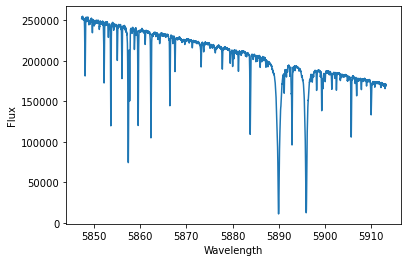

In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import time
from scipy import interpolate
import math
from spectrum_overload import Spectrum
%matplotlib inline

print('Loading...')

## Initializing Arrays
flux_obs_load  = []
wave_obs_load  = []
blaze_obs_load = []
bary_obs_load = []
file_name = []
wave_name = []
blaze_name = []
airmass = []

for path, sub, files in os.walk('../Solar_Spectra/data'):
    for name in files:
        if name.endswith("S2D_A.fits"):
            fn = path+'/'+name
            flux = fits.getdata(fn,1) # flux corrected from blaze
            wave = fits.getdata(fn,5)  # wavelength solution in the air
            header = fits.getheader(fn)
            bary = header['HIERARCH TNG QC BERV']
            airmass.append(header['AIRMASS'])
            flux_obs_load.append(flux)
            wave_obs_load.append(wave)
            bary_obs_load.append(bary)
            file_name.append(fn)

Airmass = np.asarray(airmass)            
Berv = np.asarray(bary_obs_load)
flux_obs_load = np.asarray(flux_obs_load)
wave_obs_load = np.asarray(wave_obs_load)


# Wavelengths have been moved to the Solar System barycenter, but we need them in observer rest frame
# Using BERV to get to observer rest frame
# Light speed in km/s
c = 299792.458
v=-Berv
for i in range(len(v)):
    wave_obs_load[i] = wave_obs_load[i] * (1.0 + v[i] / c)    
print('Done Loading')
print('Flux Dimension: [n_obs,n_order,n_pixel]',flux_obs_load.shape)
Data = np.array([flux_obs_load,wave_obs_load]) # Collecting flux and wavelength into same array. Data[0] is flux. 

# Plotting a raw observation
obs_id = 0
order = 53
plt.plot(Data[1,obs_id,order],Data[0,obs_id,order])
plt.xlabel('Wavelength');
plt.ylabel('Flux');

### Filtering Observations

In [2]:
# Filtering away observation with airmass > 2.0
index1 = []
for i in range(len(Airmass)):
    if  Airmass[i]  > 2: 
        index1.append(i)          

# Filtering the observations from index out 
if len(index1)>0:
    Data = np.delete(Data, index1 ,axis=1)
    Airmass = np.delete(Airmass,index1,axis=0)
    Berv = np.delete(Berv,index1,axis=0)
    print('Number of removed spectra for high airmass:',len(index1))

# Finding mean flux of spectra
means = np.zeros(len(Data[0]))
for i in range(len(Data[0])):
    means[i] = np.mean(Data[0,i,:])
    
#Some of the observations may have very low flux values. 
# Finding index of low flux observations
index2 = []
for i in range(len(Data[0])):
    if  np.max(means) / np.mean(Data[0,i,:])  > 1.2: 
        index2.append(i)       

# Filtering the low flux observations from index out 
if len(index2)>0:
    filtered_Data = np.delete(Data, index2 ,axis=1)
    Airmass = np.delete(Airmass,index2,axis=0)
    Berv = np.delete(Berv,index2,axis=0)
    print('Number of removed spectra for low flux:',len(index2)) 
    
if len(index2)==0:
    filtered_Data=Data

D = filtered_Data.transpose(1,2,0,3) # Transposing data array to have observations as first index

# Finding mean flux of spectra and saving for later scaling 
means = np.zeros(len(D))
for i in range(len(D)):
    means[i] = np.mean(D[i,:])
const = np.log(np.mean(means))

### Interpolating to common wavelength axis and continuum normalizing spectra

In [3]:
K = D.shape[1]       # number of apertures to combine (here 69)
resolution = D.shape[3] # number of pixels (here 4096)

combined_wave = np.zeros((K,resolution))
combined_flux = np.zeros((K,D.shape[0],resolution))
for k in range(K):

    # Interpolating to common restframe grid of wavepoints 
    aperture = k

    # Finding min and max for interpolation. 
    # This is needed as the observations do not cover the exact same wavelength regions
    MIN =  math.ceil(np.min(D[:,aperture,1,0]))   # Wave min
    MAX =  math.floor(np.max(D[:,aperture,1,-1])) # Wave max

    common_wave = np.linspace(MIN, MAX, num=resolution) 
    interpol_flux = []

    for i in range(len(D)):
        flux = D[i,aperture,0,:]  
        wave = D[i,aperture,1,:]
        f = interpolate.interp1d(wave, flux)

        int_flux = f(common_wave)   # use interpolation function returned by `interp1d`
        interpol_flux.append(int_flux)
    interpol_flux = np.array(interpol_flux)
    val_save = interpol_flux   
    
    # Continuum normalisation
    # Can be performed with your own choice of continuum normalization procedure
    # Here using spectrum_overload package
    interpol_flux=np.log(interpol_flux) # taking log of spectrum 
    normalized_flux = np.zeros((len(interpol_flux),len(interpol_flux[0])))
    for j in range(len(interpol_flux)):
        s = Spectrum(flux=interpol_flux[j], xaxis=common_wave)
        continuum = s.continuum(method="linear", nbins=10, ntop=5) # Optimal continuum normalisaton params can depend on spectrum size
        normalized_flux[j] = interpol_flux[j]/continuum.flux
    interpol_flux=normalized_flux
    
    # Combining the wave function and flux of each aperture
    combined_wave[k] = common_wave
    combined_flux[k] = interpol_flux
    
Preproc_wave=combined_wave
Preproc_flux=combined_flux.transpose(1,0,2)
Preproc_airmass = Airmass
Preproc_berv = Berv

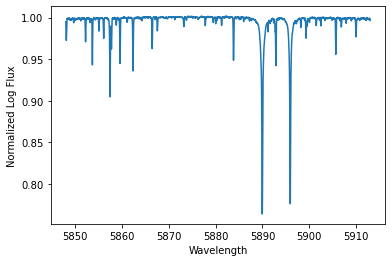

In [4]:
# Plotting a preprocessed observation
obs_id = 0
order = 53
plt.plot(Preproc_wave[order],Preproc_flux[obs_id,order])
plt.xlabel('Wavelength');
plt.ylabel('Normalized Log Flux');

### Saving Preproc Data

In [5]:
# Save file
#output = open('../preproc/preproc_wave.pkl', 'wb')
#pickle.dump(preproc_wave, output)
#output.close()

#output = open('../preproc/preproc_flux.pkl', 'wb')
#pickle.dump(Preproc_flux, output)
#output.close()

#output = open('../preproc/preproc_airmass.pkl', 'wb')
#pickle.dump(preproc_airmass, output)
#output.close()

#output = open('../preproc/preproc_berv.pkl', 'wb')
#pickle.dump(preproc_berv, output)
#output.close()

#output = open('../preproc/preproc_const.pkl', 'wb')
#pickle.dump(const, output)
#output.close()